Análisis de Flujos de Fondos
===

* 60:00 min | Última modificación: Juno 22, 2019 | YouTube

### Criterio del valor presente neto 

![assets/analysis.png](assets/analysis.png)


**Criterio del valor presente.**

$$PV(r) = \sum_{t=0}^N \frac{F_t}{(1+r)^t}$$

* Si $PV(r) > 0$, acepte.
* Si $PV(r) = 0$, indiferencia.
* Si $PV(r) < 0$, rechace.

**Criterio del valor futuro.**

$$FV(r) = \sum_{t=0}^N \frac{F_t}{(1+r)^{N-t}}$$

* Si $FV(r) > 0$, acepte.
* Si $FV(r) = 0$, indiferencia.
* Si $FV(r) < 0$, rechace.

**Criterio del equivalente uniforme períodico.**

$$UPE(r) = PV(r) * \frac{r * (1+r)^N}{(1+r)^N-1}$$

* Si $UPE(r) > 0$, acepte.
* Si $UPE(r) = 0$, indiferencia.
* Si $UPE(r) < 0$, rechace.

**Nota 1.** $r$ es la MARR y puede variar de período a período.

**Nota 2.** El $PV(r)$ representa el excedente que se gana sobre la alternativa de invertir a una tasa de $r$.

`timevalue(cflo, marr, base_date=0)`

donde:

* `cflo` -- flujo neto de efectivo.
* `marr` -- tasa mínima atractiva de retorno.
* `base_date` -- período base para calcular el valor equivalente.

La función retorna el valor único equivalente. Para `base_date=0` corresponde al valor presente neto; para `base_date = nper` corresponde al valor futuro neto.


**Ejemplo.--** Calcule los indicadores para el siguiente flujo de efectivo, si la tasa de descuento es del 10%.

![assets/diagrama-vpn.png](assets/diagrama-vpn.png)


In [1]:
import cashflows as cf

cflo = cf.cashflow(const_value=[-1000, 400, 360, 320, 280, 240], start=2000)
cflo

2000   -1000.0
2001     400.0
2002     360.0
2003     320.0
2004     280.0
2005     240.0
Freq: A-DEC, dtype: float64

In [2]:
## valor presente neto
cf.timevalue(cflo  = cflo,
             prate = cf.interest_rate([10]*6, start=2000))

241.84264611831009

In [3]:
## valor futuro neto
cf.timevalue(cflo  = cflo,
             prate = cf.interest_rate([10]*6, start=2000),
             base_date = 5  )

389.49000000000012

In [4]:
## la función puede recibir simultaneamente varios flujos de efectivo
cf.timevalue(cflo  = [cflo, cflo, cflo],
              prate = cf.interest_rate([10]*6, start=2000))

0    241.842646
1    241.842646
2    241.842646
dtype: float64

### Tasa interna de retorno (IRR)

$r^*$ -- tasa interna de retorno (irr). Es la tasa que hace el valor presente igual a cero.

$$PV(r^*) = \sum_{t=0}^N \frac{F_t}{(1+r^*)^t} ~=~0$$

**Ejemplo.--** Calcule la irr para el ejemplo anterior.

In [6]:
import cashflows as cf
cflo = cf.cashflow(const_value=[-1000, 400, 360, 320, 280, 240], start=2000)
cf.irr(cflo)

20.000000000000018

In [7]:
cf.irr([cflo, cflo, cflo])

0    20.0
1    20.0
2    20.0
dtype: float64

### Tasa Interna de Retorno Modificada

![assets/mirr.png](assets/mirr.png)

$$(1+MIRR)^N = \frac{\sum_{t=0}^N \max(F_t,0) * (1+r_1)^{N-t} }{ \sum_{t=0}^N \min(F_t,0) * (1+r_2)^{-t} }$$

$r_1$ -- tasa de reinversión.   
$r_2$ -- tasa de financiamiento.

In [8]:
cf.mirr(cflo=cflo, finance_rate=0, reinvest_rate=0)

9.8560543306117854

### Análisis de sensibilidad

Se realiza variando una de las variables del problema para determinar el efecto en el indicador utilizado.

**Ejemplo.--** Se tiene un proyecto con la siguiente información:

* Años de operación: 10
* Años de construcción: 1
* Producción: 1000 unidades por año
* Precio de venta: `$` 10 por unidad
* Costos operativos: `$` 220 por año
* Costos de inversión: `$` 2000 depreciables a 10 años.
* MARR = 10%
* Impuesto de renta: 30%

Construya la gráfica de sensibilidad del npv a la producción, el precio de venta y la inversión.

In [10]:
## se construye una función que recibe la información 
## relevante y retorn el npv

def project(marr,
            produccion, 
            precio, 
            costo,
            inversion):
    
    # ingresos operativos
    ingre = cf.cashflow(const_value=[0] + [precio*produccion]*10, start=2018) 
    
    # costos operativos
    opera = cf.cashflow(const_value=[0] + [costo]*10, start=2018)
    
    # inversión
    inver = cf.cashflow(const_value=[inversion] + [0]*10, start=2018)
    
    # vida útil de la inversión
    life = cf.cashflow(const_value=[10] + [0]*10, start = 2018)
    
    # depreciación
    dep = cf.depreciation_sl(costs=inver, life=life)['Depr']
                        
        
        
    # utilidad antes de impuestos
    antes = ingre - opera - inver - dep
    
    tax_rate = cf.interest_rate(const_value=[30]*11, start=2018)
    
    impue = cf.after_tax_cashflow(antes, tax_rate=tax_rate)
    
    neto = antes + impue

    npv = cf.timevalue(cflo=neto, prate=cf.interest_rate([marr]*11, start=2018))
    
    return npv

In [11]:
project(marr=10, produccion=100, precio=10, costo=220, inversion=2000)

2633.0035977013285

In [12]:
## resultados para diferentes valores de la MARR
x=[]
for i in [8, 10, 12]:
    x.append(project( i, 100, 10, 220, 2000))
x

[3059.4013748018465, 2633.0035977013285, 2260.2681634217906]

In [13]:
## resultados para diferentes valores de la inversión
[project(10, 100, 10, 220, x) for x in [1600, 1800, 2000, 2200, 2400]]

[3352.5210871979721,
 2992.7623424496505,
 2633.0035977013285,
 2273.244852953007,
 1913.486108204685]

In [14]:
## resultados para diferentes valores del precio
[project(10, 100, x, 220, 2000) for x in [8, 9, 10, 11, 12]]

[1035.4161502181119,
 1834.2098739597204,
 2633.0035977013285,
 3431.7973214429371,
 4230.5910451845448]

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
precio = [8, 9, 10, 11, 12]
y = [project(0.10, 100, x, 220, 2000) for x in precio]

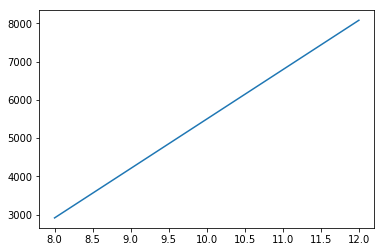

In [17]:
plt.plot(precio, y)

**Ejercicio.--** Grafique las sensibilidades al costo y a la producción.